# Usage of the ReflectedBackground class with Gammapy

In this tutorial we will learn how to use the Reflected Bkg and we will describe its new features. For reminder, this algorithm is used for the 1D spectral analysis.

If you're interested in the full pipeline for the 1D spectral analysis, you should read ([spectrum_pipe.ipynb](spectrum_pipe.ipynb)) that executes the analysis using high-level classes and methods in Gammapy. 

In this tutorial we will use the folling Gammapy classes:

- [astropy.data.DataStore](https://docs.gammapy.org/dev/api/gammapy.data.DataStore.html) to load the data
- [astropy.regions](https://astropy-regions.readthedocs.io/en/latest/) to select different shapes on On test (or test region)
- [gammapy.background.ReflectedRegionsBackgroundEstimator](https://docs.gammapy.org/dev/api/gammapy.background.ReflectedRegionsBackgroundEstimator.html) to run the Reflected Background algorithm

We use 4 Crab observations from H.E.S.S. for testing.

## Setup

As usual, we'll start with some setup for the notebook, and import the functionality we need.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import PixCoord, CircleSkyRegion, CircleAnnulusSkyRegion, EllipseSkyRegion, EllipseAnnulusSkyRegion, RectangleSkyRegion, RectangleAnnulusSkyRegion, PolygonSkyRegion

from gammapy.data import DataStore
from gammapy.catalog import SourceCatalogGammaCat
from gammapy.maps import Map, WcsGeom
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.stats import significance_on_off

## Select data

First, we select and load some H.E.S.S. data (DL3 public test data release 1). In real life you would do something fancy here, or just use the list of observations someone send you (and hope they have done something fancy before). We'll just use the standard gammapy 4 crab runs.

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
observations = data_store.get_observations(obs_ids)
print(obs_ids)

crab_pos = SkyCoord.from_name("crab")
print("\nCrab coordinates: {}".format(crab_pos))

[23523 23526 23559 23592]

Crab coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>


## Defining the Exclusion regions

Some areas of the sky might be known to contain gamma-ray sources or to exhibit large scale gamma-ray emission. Such area should be excluded when running the Reflected Bkg algorithm in order to not 'contaminate' the Bkg estimation. Let's use the [gamma-cat](https://gamma-cat.readthedocs.io/) catalog of known gamma-ray sources.

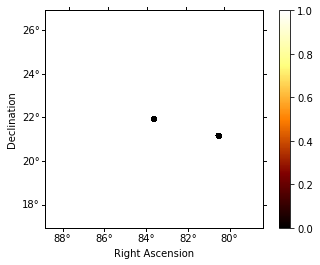

In [3]:
exclusion_mask = Map.create(skydir=crab_pos, width=(10, 10), binsz=0.02)

gammacat = SourceCatalogGammaCat("$GAMMAPY_DATA/catalogs/gammacat/gammacat.fits.gz")

regions = []
for source in gammacat:
    if not exclusion_mask.geom.contains(source.position):
        continue
    region = CircleSkyRegion(source.position, 0.15 * u.deg)
    regions.append(region)
exclusion_mask.data = exclusion_mask.geom.region_mask(regions, inside=False)
exclusion_mask.plot(add_cbar=True);

## Small introduction to the Astropy.Region API

Different shapes of regions are available. Except the polygons shapes, all other are supported by the Reflected Background algorithm: [astropy.regions.CircleSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html#regions.CircleSkyRegion), [astropy.regions.CircleAnnulusSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.CircleAnnulusSkyRegion.html#regions.CircleAnnulusSkyRegion), [astropy.regions.EllipseSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.EllipseSkyRegion.html#regions.EllipseSkyRegion), [astropy.regions.EllipseAnnulusSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.EllipseAnnulusSkyRegion.html#regions.EllipseAnnulusSkyRegion), [astropy.regions.RectangleSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.RectangleSkyRegion.html#regions.RectangleSkyRegion), [astropy.regions.RectangleAnnulusSkyRegion](https://astropy-regions.readthedocs.io/en/latest/api/regions.RectangleAnnulusSkyRegion.html#regions.RectangleAnnulusSkyRegion).
Some exemples are given to define them and to plot them.

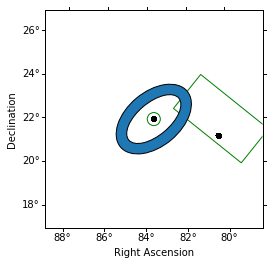

In [4]:
on_circle = CircleSkyRegion(crab_pos, 0.3 * u.deg)
on_rectangle = RectangleSkyRegion(center=SkyCoord(80.3,22.0,unit="deg"),
                                    width=2. * u.deg, height=4. * u.deg,
                                    angle=50 * u.deg)
on_ellipse_annulus = EllipseAnnulusSkyRegion(center=crab_pos,
                                               inner_width=1.5 * u.deg,
                                               outer_width=2.5 * u.deg,
                                               inner_height=3 * u.deg,
                                               outer_height=4 * u.deg,
                                               angle=130 * u.deg)
exclusion_mask.plot();
on_circle.to_pixel(exclusion_mask.geom.wcs).plot();
on_rectangle.to_pixel(exclusion_mask.geom.wcs).plot();
on_ellipse_annulus.to_pixel(exclusion_mask.geom.wcs).plot();

Such geometrical shapes can be use to add a region in the Exclusion Region map built before with the GammaCat catalog.

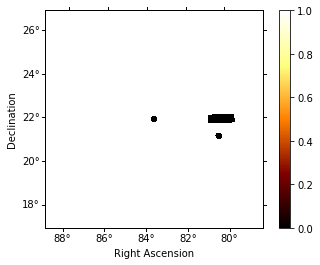

In [5]:
exc_region = RectangleSkyRegion(center=SkyCoord(80.3,22.0,unit="deg"),
                                    width=1.2 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
regions.append(exc_region)
exclusion_mask.data = exclusion_mask.geom.region_mask(regions, inside=False)
exclusion_mask.plot(add_cbar=True);

## Configure the analysis

Now we'll define the input for the ReflectedBkg analysis. It will be done the python way, i.e. by creating a config dict containing python objects.

In [6]:
print("\nCrab coordinates: {}".format(crab_pos))
rectangle_sky = RectangleSkyRegion(center=crab_pos,
                                    width=0.5 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
config = dict(
    outdir=".",
    background=dict(
        on_region=rectangle_sky,
        exclusion_mask=exclusion_mask,
        min_distance=0.1 * u.rad,
    )
)
background_estimator = ReflectedRegionsBackgroundEstimator(
            observations=observations, **config["background"])


Crab coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>


## Result of the analysis

Let's run the maker, look at the reflected regions used to estimate the Bkg and print the final statistics

In [7]:
background_estimator.run()

Found 3 reflected regions for the Obs #23523


/home/khelifi/MesProgrammes/gammapy_dev/gammapy/data/event_list.py:597: RuntimeWarning: invalid value encountered in greater
  valid = values > 0


Found 3 reflected regions for the Obs #23526
Found 13 reflected regions for the Obs #23559
Found 11 reflected regions for the Obs #23592


/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in l

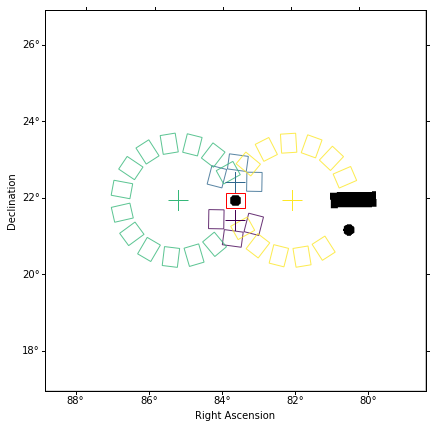

In [8]:
background_estimator.plot();

In [9]:
on_s = 0
off_s = 0
a_on_s = 0
a_off_s = 0
for obs_result in background_estimator.result:
    on_s += len(obs_result.on_events.table)
    off_s += len(obs_result.off_events.table)
    a_on_s += obs_result.a_on
    a_off_s += obs_result.a_off
    print(obs_result)
    print("\n")

alpha = a_on_s/a_off_s
excess = on_s - off_s*alpha
sigma = significance_on_off(on_s, off_s, alpha)
print("\n Total ON : {0} | Total OFF : {1} | Alpha : {2:.4f}".format(on_s, off_s, alpha))
print(" Total Excess : {0:.2f} | Sigma = {1:.2f}".format(excess, sigma))

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: RectangleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>
width: 0.5 deg
height: 0.4 deg
angle: 0.0 deg
 EventList info:
- Number of events: 365
- Median energy: 0.952 TeV
- OBS_ID = 23523
 off region
 [<RectangleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (84.17078346, 21.52247617)>, width=0.5000190603305097 deg, height=0.4000152482644078 deg, angle=1.55691566690431 rad)>, <RectangleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.7054863, 21.01893013)>, width=0.5000003852470228 deg, height=0.40000030819761834 deg, angle=3.007411225598797 rad)>, <RectangleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.11330698, 21.38874838)>, width=0.5000178511938463 deg, height=0.4000142809550771 deg, angle=4.457094651601051 rad)>]
 EventList info:
- Number of events: 306
- Median energy: 0.753 TeV
- OBS_ID = 23523


BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: Rectangle

## Features associated to the 'ON region'


As seen in the previous plot, the refelcted regions seem to be here defined in the RA-DEC frame (on the sphere). In fact, there are built on the tangential plane to the pointing direction (thus on the plane).

Let's now precise an interesting feature. In the constructor of the ON region, called here 'rectangle_sky', the definition of 'width', 'height' and 'angle' is made on the frame of the 'center', ie the rectangle is aligned to the axes of the center's frame.
So, if the center is defined in the galactic frame, the orientation of the rectangle will be different. The ON region will be different.

/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


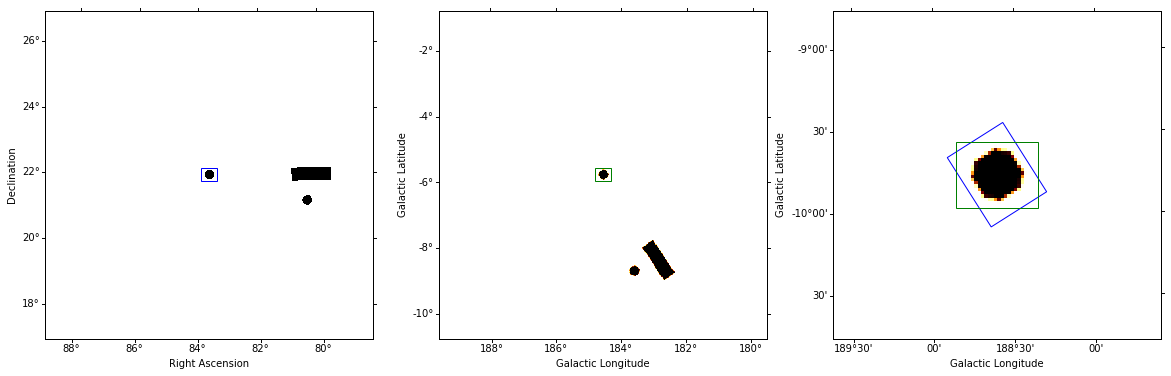

In [10]:
rectangle_radec = RectangleSkyRegion(center=crab_pos,
                                    width=0.5 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
rectangle_gal = RectangleSkyRegion(center=crab_pos.transform_to('galactic'),
                                    width=0.5 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
plt.figure(figsize=(20,40))

ax1 = plt.subplot(131, projection=exclusion_mask.geom.wcs)
exclusion_mask.plot(ax=ax1);
rectangle_radec.to_pixel(exclusion_mask.geom.wcs).plot(color='blue', ax=ax1);

gal_wcs_geom = WcsGeom.create(
    binsz=0.02, width=exclusion_mask.geom.width, skydir=exclusion_mask.geom.center_skydir, coordsys="GAL")
ax2 = plt.subplot(132, projection=gal_wcs_geom.wcs)
gal_exclusion_mask = exclusion_mask.reproject(gal_wcs_geom)
gal_exclusion_mask.plot(ax=ax2);
rectangle_gal.to_pixel(gal_wcs_geom.wcs).plot(ax=ax2);

ax3 = plt.subplot(133, projection=gal_wcs_geom.wcs)
gal_exclusion_mask_2 = exclusion_mask.reproject(gal_wcs_geom).cutout(exclusion_mask.geom.center_skydir, Angle('2deg'))
gal_exclusion_mask_2.plot(ax=ax3);
rectangle_radec.to_pixel(gal_exclusion_mask_2.geom.wcs).plot(color='blue', ax=ax3);
rectangle_gal.to_pixel(gal_exclusion_mask_2.geom.wcs).plot(ax=ax3);

So, let's run the ReflectedBkg class with a RectangleSkyRegion defined in the GAL frame and compare the results.

Found 4 reflected regions for the Obs #23523


/home/khelifi/MesProgrammes/gammapy_dev/gammapy/data/event_list.py:597: RuntimeWarning: invalid value encountered in greater
  valid = values > 0


Found 4 reflected regions for the Obs #23526
Found 10 reflected regions for the Obs #23559
Found 9 reflected regions for the Obs #23592


/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"



 Total ON : 1329 | Total OFF : 2103 | Alpha : 0.1481
 Total Excess : 1017.44 | Sigma = 37.98


/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/khelifi/MesProgrammes/anaconda3/lib/python3.6/site-packages/astropy/visualization/mpl_normalize.py:111: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)

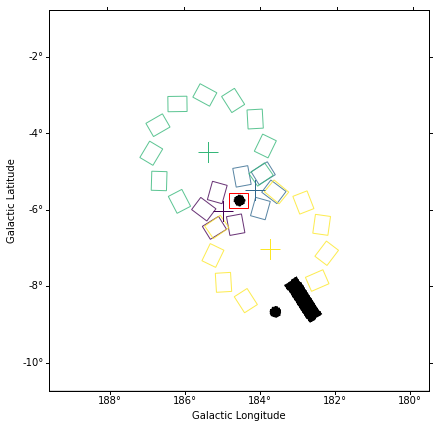

In [11]:
gal_rectangle_sky = RectangleSkyRegion(center=crab_pos.transform_to('galactic'),
                                    width=0.5 * u.deg, height=0.4 * u.deg,
                                    angle=0 * u.deg)
config = dict(
    outdir=".",
    background=dict(
        on_region = gal_rectangle_sky,
        exclusion_mask=exclusion_mask,
        min_distance=0.1 * u.rad,
    )
)
gal_background_estimator = ReflectedRegionsBackgroundEstimator(
            observations=observations, **config["background"]
        )
gal_background_estimator.run()
gal_background_estimator.plot();
on_s = 0
off_s = 0
a_on_s = 0
a_off_s = 0
for obs_result in gal_background_estimator.result:
    on_s += len(obs_result.on_events.table)
    off_s += len(obs_result.off_events.table)
    a_on_s += obs_result.a_on
    a_off_s += obs_result.a_off

alpha = a_on_s/a_off_s
excess = on_s - off_s*alpha
sigma = significance_on_off(on_s, off_s, alpha)
print("\n Total ON : {0} | Total OFF : {1} | Alpha : {2:.4f}".format(on_s, off_s, alpha))
print(" Total Excess : {0:.2f} | Sigma = {1:.2f}".format(excess, sigma))

Compared to the previous results [Total ON : 1345 | Total OFF : 2252 | Alpha : 0.1333
 Total Excess : 1044.73 | Sigma = 39.56], all the statistics are logically slightly different.
 
 __Summary of the features:__
 1. The ReflectedBackground class admits now several shapes for the ON region (or test region)
 2. The reflected regions are computed for each observation in the tangential frame centered on observation position and based on the frame of the center of the ON region
 3. The ON region is always defined in the frame the center of the region (in particular its orientation), which leads to results of The ReflectedBackground class depending of the frame of the center of the region